<a href="https://colab.research.google.com/github/hakim-code/CSV-to-GluonTS-Converter/blob/update-structure-and-description/Data_Format_csv_to_gluonTS_Converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
!pip install -q datasets gluonts orjson mxnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.9 MB/s eta 0:00:00


In [45]:
import pandas as pd
import numpy as np
from datasets import Dataset, Features, Value, Sequence
from typing import cast
from gluonts.mx import DeepAREstimator, Trainer
from gluonts.dataset.pandas import PandasDataset
from gluonts.evaluation import make_evaluation_predictions, Evaluator

# Time Series Datasets

#1: Pandas dataset:
* Import
* Dataframe summary

In [38]:
path = "/content/PJME_hourly_shorted.csv"
df = pd.read_csv(path,  index_col=0,  parse_dates=True) #index_col=0,

df.index = pd.DatetimeIndex(df.index)
df.head(5)

,PJME_MW
Datetime,
2002-01-02 00:00:00,29563
2002-01-02 01:00:00,28121
2002-01-02 02:00:00,27437
2002-01-02 03:00:00,27301
2002-01-02 04:00:00,27533


In [50]:
# Getting the shape
print("Shape of the DataFrame:", df.shape)

# Getting the total number of elements
print("Total number of elements:", df.size)

# Getting the number of rows
print("Number of rows:", len(df))

# Getting the number of columns
print("Number of columns:", df.shape[1])

# Getting detailed info
df.info()

Shape of the DataFrame: (1392, 1)
Total number of elements: 1392
Number of rows: 1392
Number of columns: 1
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1392 entries, 2002-01-02 00:00:00 to 2002-02-28 23:00:00
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   PJME_MW  1392 non-null   int64
dtypes: int64(1)
memory usage: 21.8 KB


##1.1: Dataset Cleaning
  

*   NaN Value (empty cell)
*   Duplicate items




In [27]:
# If there are any NaN values, print their locations
nan_rows = df[df.isnull().any(axis=1)]
if not nan_rows.empty:
    print("NaN values found at the following locations:")
    print(nan_rows)

duplicate_times = df.index[df.index.duplicated()].unique()
# If there are any duplicate times, print them
if len(duplicate_times) > 0:
    print("Duplicate datetimes found:")
    print(duplicate_times)




##1.2: Dataset Cleaning: Frequency checker
  

*   Frequency of the data of the data must be exact. Is there any seconds which exceeds or less than an hour the frequency can not be inferred.
*   if any export them in excel data


In [28]:
# Create a full range of hourly timestamps expected in the DataFrame
full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='H')

# Identify missing timestamps by comparing the full range with the DataFrame's index
missing_timestamps = full_range.difference(df.index)

# If there are any missing timestamps, print their locations and export to Excel
if missing_timestamps.size > 0:
    print("The following timestamps are missing:")
    print(missing_timestamps)

    # Convert the missing timestamps to a DataFrame
    missing_df = pd.DataFrame(missing_timestamps, columns=['Missing Timestamps'])

    # Export the missing timestamps to an Excel file
    missing_df.to_excel('/content/missing_timestamps.xlsx', index=False)

    print("Missing timestamps have been exported to Excel.")
else:
    print("The frequency is consistent and there are no missing hourly timestamps.")


The frequency is consistent and there are no missing hourly timestamps.


In [29]:
inferred_freq = pd.infer_freq(df.index)
print(inferred_freq)
if inferred_freq:
    print(f"Inferred frequency from the DataFrame: {inferred_freq}")

    # Create a full range of datetimes with the inferred frequency and compare with the existing index
    full_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=inferred_freq)
    missing_times = full_range.difference(df.index)

    # If there are any missing times, print them
    if len(missing_times) > 0:
        print("Missing datetimes found:")
        print(missing_times)
    else:
        print("No missing datetimes. The frequency is consistent.")
else:
    print("Could not infer a consistent frequency from the DataFrame index.")


H
Inferred frequency from the DataFrame: H
No missing datetimes. The frequency is consistent.


#1.3: Data visualization

<Axes: xlabel='Datetime'>

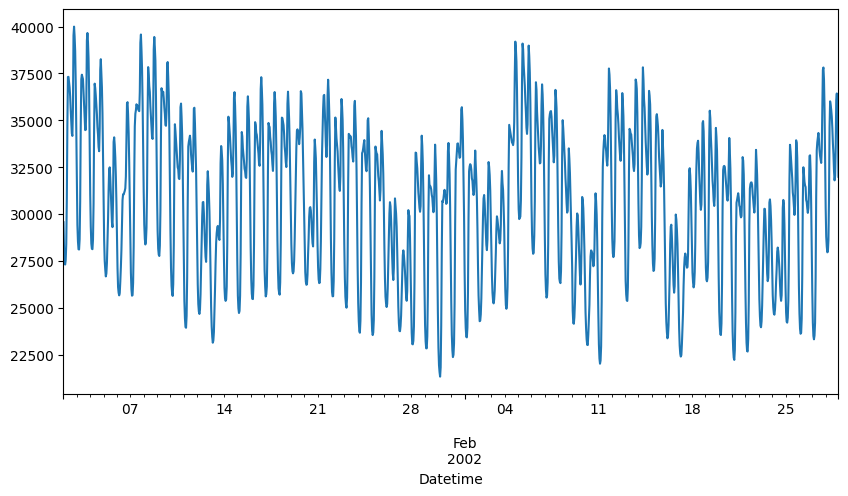

In [30]:
df.loc[:, "PJME_MW"].plot(figsize=(10, 5))

#2: Format conversion to GluonTS
*  target = trained, predicted variable

In [32]:
prediction_length, freq = 24, "1H"
# ds = PandasDataset.from_long_dataframe(df, target="PJME_MW")
ds = PandasDataset(df, target="PJME_MW", freq=freq)
ds

PandasDataset<size=1, freq=1H, num_feat_dynamic_real=0, num_past_feat_dynamic_real=0, num_feat_static_real=0, num_feat_static_cat=0, static_cardinalities=[]>

In [39]:
# from gluonts.dataset.pandas import PandasDataset

#ds = PandasDataset.from_long_dataframe(df, target="PJME_MW", item_id = "item_id")

# Counting the number of time series entries
num_time_series = sum(1 for _ in ds)
print(f"Number of time series entries: {num_time_series}")

# Inspecting the first few entries
for i, entry in enumerate(ds):
    if i < 5:  # Change this number to see more entries
        print(f"Entry {i}:")
        print(entry)
        print(f"Length of target in entry {i}: {len(entry['target'])}\n")

Number of time series entries: 1
Entry 0:
{'start': Period('2002-01-02 00:00', 'H'), 'target': array([29563, 28121, 27437, ..., 35866, 34631, 31986])}
Length of target in entry 0: 1392



In [34]:
# To check duplicates

ids = df.index
df[ids.isin(ids[ids.duplicated()])].sort_values("Datetime")

,PJME_MW
Datetime,


#2.1: Preprocess Data Entries before using GluonTS


*   conversion into expected format in GluonTS
*   assign the values and return them into a dictionary



In [40]:
class ProcessStartField():
    ts_id = 0 #init, bertambah setiap kali method __call__

    def __call__(self, data): #__call__ method allow instance to be called like a function
        data["start"] = data["start"].to_timestamp()#ubah format start ke timestamp as expected in Gluon
        data["feat_static_cat"] = [self.ts_id]#add variabel ke dalam feat_static_cat useful for multiple time series
        self.ts_id += 1

        return data

#2.2: Mapping dataset into instance
* interact customized dataset with gluonTS library
*  list_ds = list of dict where each of dict compatible with the structure defined my method "features".

In [41]:
from gluonts.itertools import Map

process_start = ProcessStartField()#instance terhasil dari kelas ProcessStartField

list_ds = list(Map(process_start, ds))#untuk terap process_start ke setiap entry ds

list_ds

[{'start': Timestamp('2002-01-02 00:00:00'),
  'target': array([29563, 28121, 27437, ..., 35866, 34631, 31986]),
  'feat_static_cat': [0]}]

#2.3: Manage Dataset with Machine Learning Library made by Huggingsface

* Feature class is used to define the data type and structure
* Value:  single value of timestamp, target is defined as 32 bit precision
* Sequence: categorical value which is as unsigned 64 bit integers in this case is None


In [48]:
from datasets import Dataset, Features, Value, Sequence

features  = Features(#setup kolum contoh start adalah time stamp dan target ialah
    {
        "start": Value("timestamp[s]"),
        "target": Sequence(Value("float32")),
        "feat_static_cat": Sequence(Value("uint64")),
        # "feat_static_real":  Sequence(Value("float32")),
        # "feat_dynamic_real": Sequence(Sequence(Value("uint64"))),
        # "feat_dynamic_cat": Sequence(Sequence(Value("uint64"))),
       # "item_id": Value("string"),
    }
)

In [49]:
dataset = Dataset.from_list(list_ds, features=features)
dataset

Dataset({
    features: ['start', 'target', 'feat_static_cat'],
    num_rows: 1
})

In [36]:
def train_and_predict(dataset, estimator):
    predictor = estimator.train(dataset)
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=dataset, predictor=predictor
    )
    evaluator = Evaluator(quantiles=(np.arange(20) / 20.0)[1:])
    agg_metrics, item_metrics = evaluator(ts_it, forecast_it, num_series=len(dataset))
    return agg_metrics["MSE"]


estimator = DeepAREstimator(
    freq=freq, prediction_length=prediction_length, trainer=Trainer(epochs=1)
)

In [37]:
train_and_predict(ds, estimator)

Running evaluation: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


11947631.486720562

In [51]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [54]:
!git config --global user.email "herrzainulhakimdalim@gmail.com"
!git config --global user.name "hakim-code"



In [60]:
!git clone "https://github.com/hakim-code/CSV-to-GluonTS-Converter"


Cloning into 'CSV-to-GluonTS-Converter'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (9/9), 115.79 KiB | 1.68 MiB/s, done.


In [57]:
!git add Data Format csv to gluonTS Converter.ipynb
# !git commit -m "Update: Structures and description wise"

fatal: not a git repository (or any of the parent directories): .git
